A recurring question is how to save and share multi-conformer molecules.
The easiest (and fastest) way to do this in the RDKit is to just pickle the molecules. It's not significantly more difficult to use `rdMolInterchange.MolToJSON()` to serialize the molecules as JSON. Neither of these methods work if you want to work with other tools, so we're frequently stuck with using something like SD files.

The topic came up in the lab today, so I figured I'd do a blog post looking at how to create and work with multi-conformer SD files as well as multi-molecule, multi-conformer SD files with the RDKit. Memo to myself: some of this should probably also end up in the Cookbook.

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)

import rdkit
print(rdkit.__version__)

2022.03.5


Start by generating conformers for doravirine, lenalidomide, and mutanobactin:

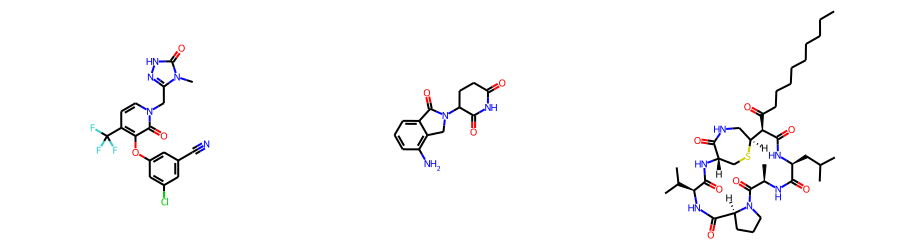

In [2]:
dorav = Chem.MolFromSmiles('Cn1c(n[nH]c1=O)Cn2ccc(c(c2=O)Oc3cc(cc(c3)Cl)C#N)C(F)(F)F')
lenal = Chem.MolFromSmiles('O=C1NC(=O)CCC1N3C(=O)c2cccc(c2C3)N')
mutanob = Chem.MolFromSmiles('CCCCCCCCCC(=O)[C@@H]1[C@@H]2CNC(=O)[C@H](CS2)NC(=O)[C@@H](NC(=O)[C@@H]3CCCN3C(=O)[C@H](NC(=O)[C@@H](NC1=O)CC(C)C)C)C(C)C')

Draw.MolsToGridImage([dorav,lenal,mutanob],subImgSize=(300,250))

In [3]:
from rdkit.Chem import rdDistGeom

ps = rdDistGeom.ETKDGv3()
ps.randomSeed = 0xf00d
ps.numThreads = 4
ps.pruneRmsThresh = 0.5


dorav = Chem.AddHs(dorav)
lenal = Chem.AddHs(lenal)
mutanob = Chem.AddHs(mutanob)

d_cids = rdDistGeom.EmbedMultipleConfs(dorav,200,ps)
l_cids = rdDistGeom.EmbedMultipleConfs(lenal,200,ps)
m_cids = rdDistGeom.EmbedMultipleConfs(mutanob,200,ps)



print(dorav.GetNumConformers(),lenal.GetNumConformers(),mutanob.GetNumConformers())

58 7 200


Now let's start with a digression and quickly demo the two easy ways of storing and retrieving this multi-conformer molecule: pickling and using JSON:

In [4]:
import pickle

pkl = pickle.dumps(dorav)
nmol = pickle.loads(pkl)
nmol.GetNumConformers()

58

In [5]:
from rdkit.Chem import rdMolInterchange
mjs = rdMolInterchange.MolToJSON(dorav)
nmol = rdMolInterchange.JSONToMols(mjs)[0]
nmol.GetNumConformers()

58

Just out of curiosity let's see how long those take:

In [6]:
%timeit pickle.dumps(dorav)

162 µs ± 1.33 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [7]:
%timeit pickle.loads(pkl)

175 µs ± 1.44 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [8]:
%timeit rdMolInterchange.MolToJSON(dorav)

646 µs ± 12.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [9]:
%timeit rdMolInterchange.JSONToMols(mjs)[0]

252 µs ± 3.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Write those to an SDF "file"

In [10]:
from io import StringIO
sio = StringIO()
w = Chem.SDWriter(sio)
for cid in d_cids:
    w.write(dorav,confId=cid)
w.flush()
sdf = sio.getvalue()

In [11]:
sdf[:100]

'\n     RDKit          3D\n\n 40 42  0  0  0  0  0  0  0  0999 V2000\n   -3.5730   -0.0689    0.9965 C   '

In [12]:
from io import BytesIO

bio = BytesIO(sdf.encode())
suppl = Chem.ForwardSDMolSupplier(bio)

ref = next(suppl)
for mol in suppl:
    ref.AddConformer(mol.GetConformer(),assignId=True)

print(ref.GetNumConformers())

58


Again: how long does this take?

In [13]:
%timeit sio=StringIO();w=Chem.SDWriter(sio);[w.write(dorav,confId=cid) for cid in d_cids];w.flush();sdf=sio.getvalue()

9.85 ms ± 213 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
%timeit bio=BytesIO(sdf.encode());suppl=Chem.ForwardSDMolSupplier(bio);ref=next(suppl);[ref.AddConformer(m.GetConformer(),assignId=True) for m in suppl]

13.1 ms ± 250 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Ok, that was pretty easy. What about handling SDFs which contain multiple conformers of more than one molecule?


Start by creating an SDF with all conformers of all three molecules:

In [16]:
from io import StringIO
sio = StringIO()
w = Chem.SDWriter(sio)

mol = Chem.Mol(dorav)
mol.SetProp('_Name','doravirine')
for cid in d_cids:
    w.write(mol,confId=cid)
mol = Chem.Mol(lenal)
mol.SetProp('_Name','lenalidomide')
for cid in l_cids:
    w.write(mol,confId=cid)
mol = Chem.Mol(mutanob)
mol.SetProp('_Name','mutanobactin')
for cid in m_cids:
    w.write(mol,confId=cid)

    
w.flush()
multimol_sdf = sio.getvalue()

And here's a function to return the molecules from a multi-molecule, multi-conformer supplier:

In [17]:
def mols_from_multimol_multiconf_supplier(supplier,propertyName='_Name'):
    mol = None
    for itm in supplier:
        if itm is None:
            continue
        if mol is None:
            mol = itm
            refVal = mol.GetProp(propertyName)
            continue
        pVal = itm.GetProp(propertyName)
        if pVal == refVal:
            mol.AddConformer(itm.GetConformer(),assignId=True)
        else:
            # we're done with the last molecule, so let's restart the next one
            res = mol
            mol = itm
            refVal = pVal
            yield res
    
    yield mol

Now try that out:

In [18]:
from io import BytesIO

bio = BytesIO(multimol_sdf.encode())
suppl = Chem.ForwardSDMolSupplier(bio)

ms = [x for x in mols_from_multimol_multiconf_supplier(suppl)]
print([m.GetNumConformers() for m in ms])

[58, 7, 200]


By default the function uses the molecule names, but we can use other property names if we want:

In [21]:
from io import StringIO
sio = StringIO()
w = Chem.SDWriter(sio)

mol = Chem.Mol(dorav)
mol.SetProp('molecule_id','doravirine')
for cid in d_cids:
    w.write(mol,confId=cid)
mol = Chem.Mol(lenal)
mol.SetProp('molecule_id','lenalidomide')
for cid in l_cids:
    w.write(mol,confId=cid)
mol = Chem.Mol(mutanob)
mol.SetProp('molecule_id','mutanobactin')
for cid in m_cids:
    w.write(mol,confId=cid)

    
w.flush()
multimol_sdf = sio.getvalue()

bio = BytesIO(multimol_sdf.encode())
suppl = Chem.ForwardSDMolSupplier(bio)

ms = [x for x in mols_from_multimol_multiconf_supplier(suppl,propertyName='molecule_id')]
print([m.GetNumConformers() for m in ms])


[58, 7, 200]
